## Celltype prediction
***

 Celltype prediction can either be performed on indiviudal cells where each cell gets a predicted celltype label, or on the level of clusters. All methods are based on similarity to other datasets, single cell or sorted bulk RNAseq, or uses know marker genes for each celltype.

We will select one sample from the Covid data, `ctrl_13` and predict celltype by cell on that sample.

Some methods will predict a celltype to each cell based on what it is most similar to even if the celltype of that cell is not included in the reference. Other methods include an uncertainty so that cells with low similarity scores will be unclassified.
There are multiple different methods to predict celltypes, here we will just cover a few of those. 

Here we will use a reference PBMC dataset that we get from scanpy datasets and classify celltypes based on two methods:

* Using scanorama for integration just as in the integration lab, and then do label transfer based on closest neighbors.
* Using ingest to project the data onto the reference data and transfer labels.



In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()


In [2]:
sc.settings.set_figure_params(dpi=80)

Read in the clustered data object.

In [3]:
adata = sc.read_h5ad('./data/results/scanpy_clustered_covid.h5ad')

In [4]:
print(adata.shape)
print(adata.raw.shape)

(5590, 3065)
(5590, 18752)


Subset for `ctrl_13` sample.

In [5]:
adata = adata[adata.obs["sample"] == "ctrl_13",:]
print(adata.shape)

(1124, 3065)


Trying to set attribute `.uns` of view, copying.


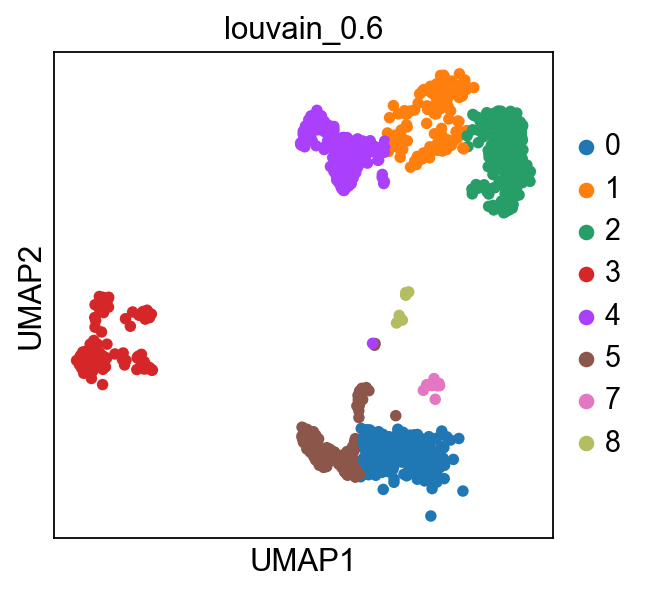

In [6]:
sc.pl.umap(
    adata, color=["louvain_0.6"], palette=sc.pl.palettes.default_20
)

### Reference data

Load the reference data from `scanpy.datasets`. It is the annotated and processed pbmc3k dataset from 10x.

In [7]:

adata_ref = sc.datasets.pbmc3k_processed() 

try downloading from url
https://raw.githubusercontent.com/chanzuckerberg/cellxgene/master/example-dataset/pbmc3k.h5ad
... this may take a while but only happens once


pbmc3k_processed.h5ad: 0.00B [00:00, ?B/s]

In [8]:
adata_ref.obs['sample']='pbmc3k'

print(adata_ref.shape)
adata_ref.obs

(2638, 1838)


,n_genes,percent_mito,n_counts,louvain,sample
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,pbmc3k
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,pbmc3k
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,pbmc3k
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,pbmc3k
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,pbmc3k
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes,pbmc3k
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells,pbmc3k
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,pbmc3k


... storing 'sample' as categorical


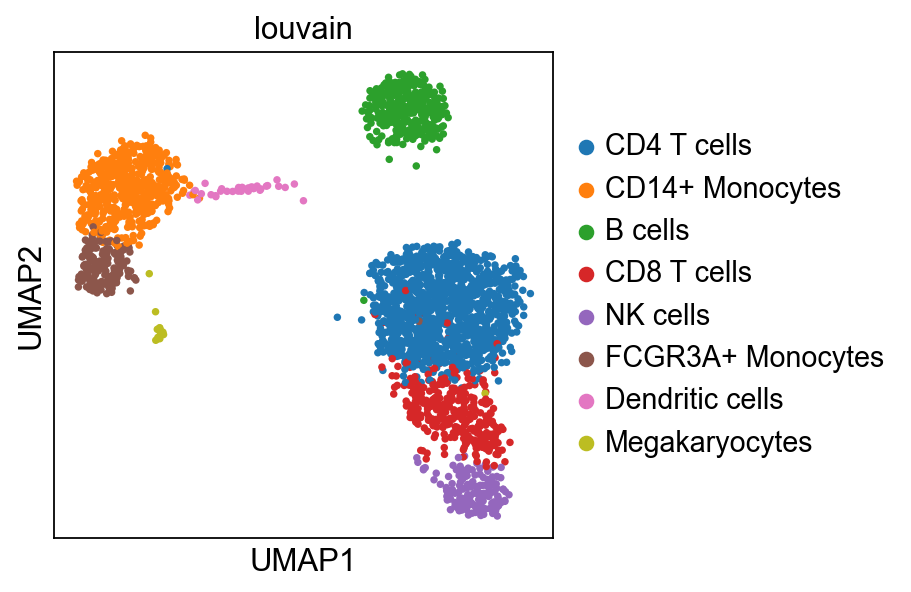

In [9]:
sc.pl.umap(adata_ref, color='louvain')

Make sure we have the same genes in both datset by taking the intersection

In [10]:
print(adata_ref.shape[1])
print(adata.shape[1])
var_names = adata_ref.var_names.intersection(adata.var_names)
print(len(var_names))

1838
3065
474


In [11]:
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]


First we need to rerun pca and umap with the same gene set for both datasets.

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02)
computing UMAP
    finished (0:00:03)


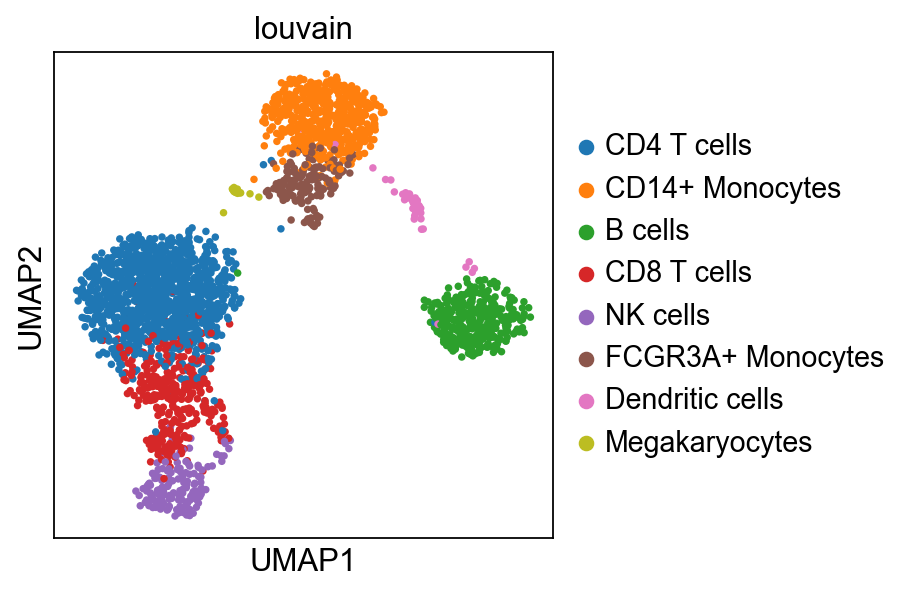

In [12]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref, color='louvain')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:01)


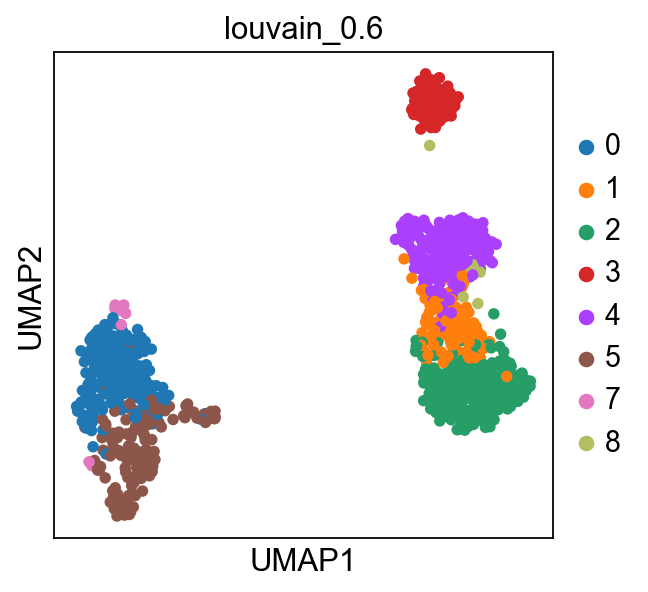

In [13]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='louvain_0.6')

## Integrate with scanorama

In [14]:
import scanorama


#subset the individual dataset to the same variable genes as in MNN-correct.
alldata = dict()
alldata['ctrl']=adata
alldata['ref']=adata_ref

#convert to list of AnnData objects
adatas = list(alldata.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

Found 474 genes among all datasets
[[0.         0.96530249]
 [0.         0.        ]]
Processing datasets (0, 1)


In [15]:
# add in sample info
adata_ref.obs['sample']='pbmc3k'


In [16]:
# create a merged scanpy object and add in the scanorama 
adata_merged = alldata['ctrl'].concatenate(alldata['ref'], batch_key='sample', batch_categories=['ctrl','pbmc3k'])

embedding = np.concatenate([ad.obsm['X_scanorama'] for ad in adatas], axis=0)

adata_merged.obsm['Scanorama'] = embedding

In [17]:
#run  umap.
sc.pp.neighbors(adata_merged, n_pcs =50, use_rep = "Scanorama")
sc.tl.umap(adata_merged)



computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:05)


... storing 'type' as categorical
... storing 'batch' as categorical
... storing 'phase' as categorical
... storing 'predicted_doublets' as categorical
... storing 'doublet_info' as categorical
... storing 'leiden_1.0' as categorical
... storing 'leiden_0.6' as categorical
... storing 'leiden_0.4' as categorical
... storing 'leiden_1.4' as categorical
... storing 'louvain_1.0' as categorical
... storing 'louvain_0.6' as categorical
... storing 'louvain_0.4' as categorical
... storing 'louvain_1.4' as categorical
... storing 'kmeans5' as categorical
... storing 'kmeans10' as categorical
... storing 'kmeans15' as categorical
... storing 'hclust_5' as categorical
... storing 'hclust_10' as categorical
... storing 'hclust_15' as categorical
... storing 'louvain' as categorical


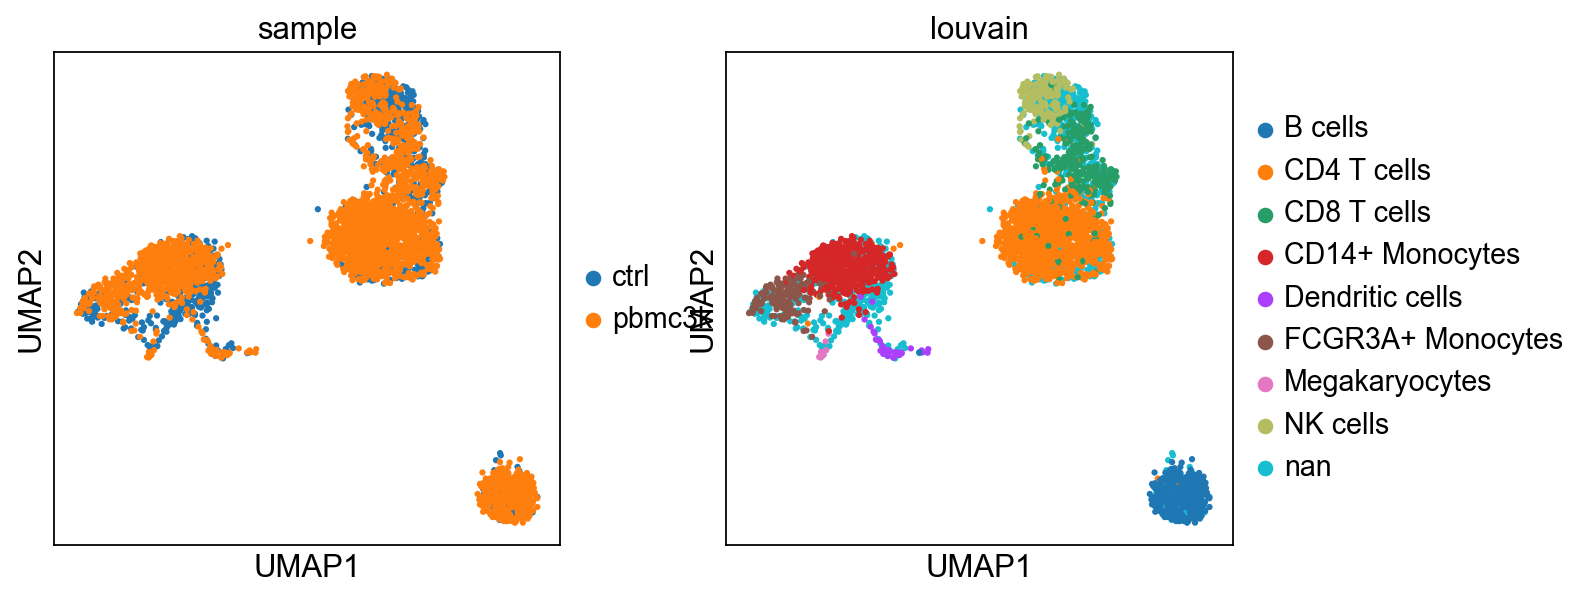

In [18]:

sc.pl.umap(adata_merged, color=["sample","louvain"])


### Label transfer

Using the function in the Spatial tutorial at the scanpy [website](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/integration-scanorama.html) we will calculate normalized cosine distances between the two datasets and tranfer labels to the celltype with the highest scores.


In [19]:
from sklearn.metrics.pairwise import cosine_distances

distances = 1 - cosine_distances(
    adata_merged[adata_merged.obs['sample'] == "pbmc3k"].obsm["Scanorama"],
    adata_merged[adata_merged.obs['sample'] == "ctrl"].obsm["Scanorama"],
)

In [20]:
def label_transfer(dist, labels, index):
    lab = pd.get_dummies(labels)
    class_prob = lab.to_numpy().T @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    # convert to df
    cp_df = pd.DataFrame(
        class_prob, columns=lab.columns
    )
    cp_df.index = index
    # classify as max score
    m = cp_df.idxmax(axis=1)
    
    return m

In [21]:
class_def = label_transfer(distances, adata_ref.obs.louvain, adata.obs.index)


In [22]:
# add to obs section of the original object
adata.obs['predicted'] = class_def


... storing 'predicted' as categorical


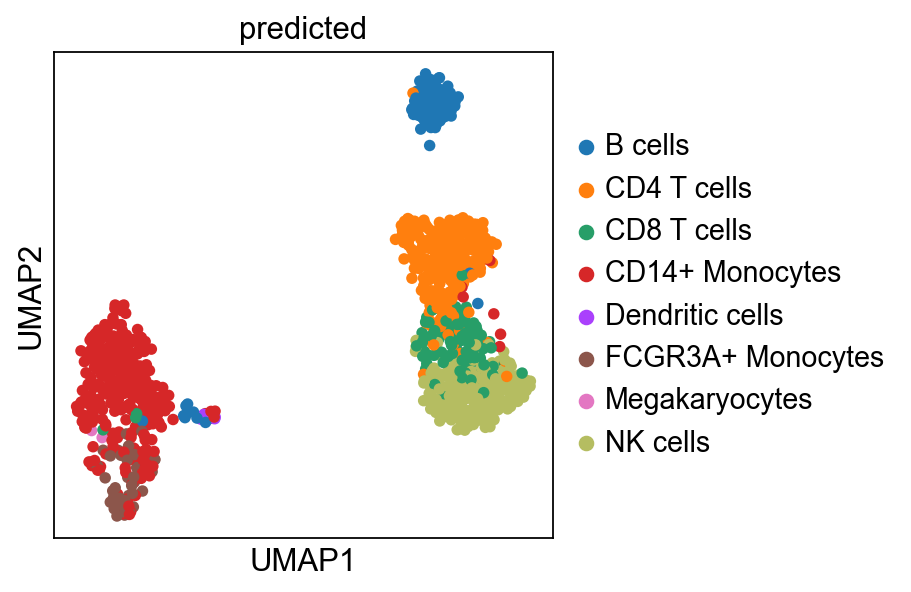

In [23]:
sc.pl.umap(adata, color="predicted")

... storing 'predicted' as categorical


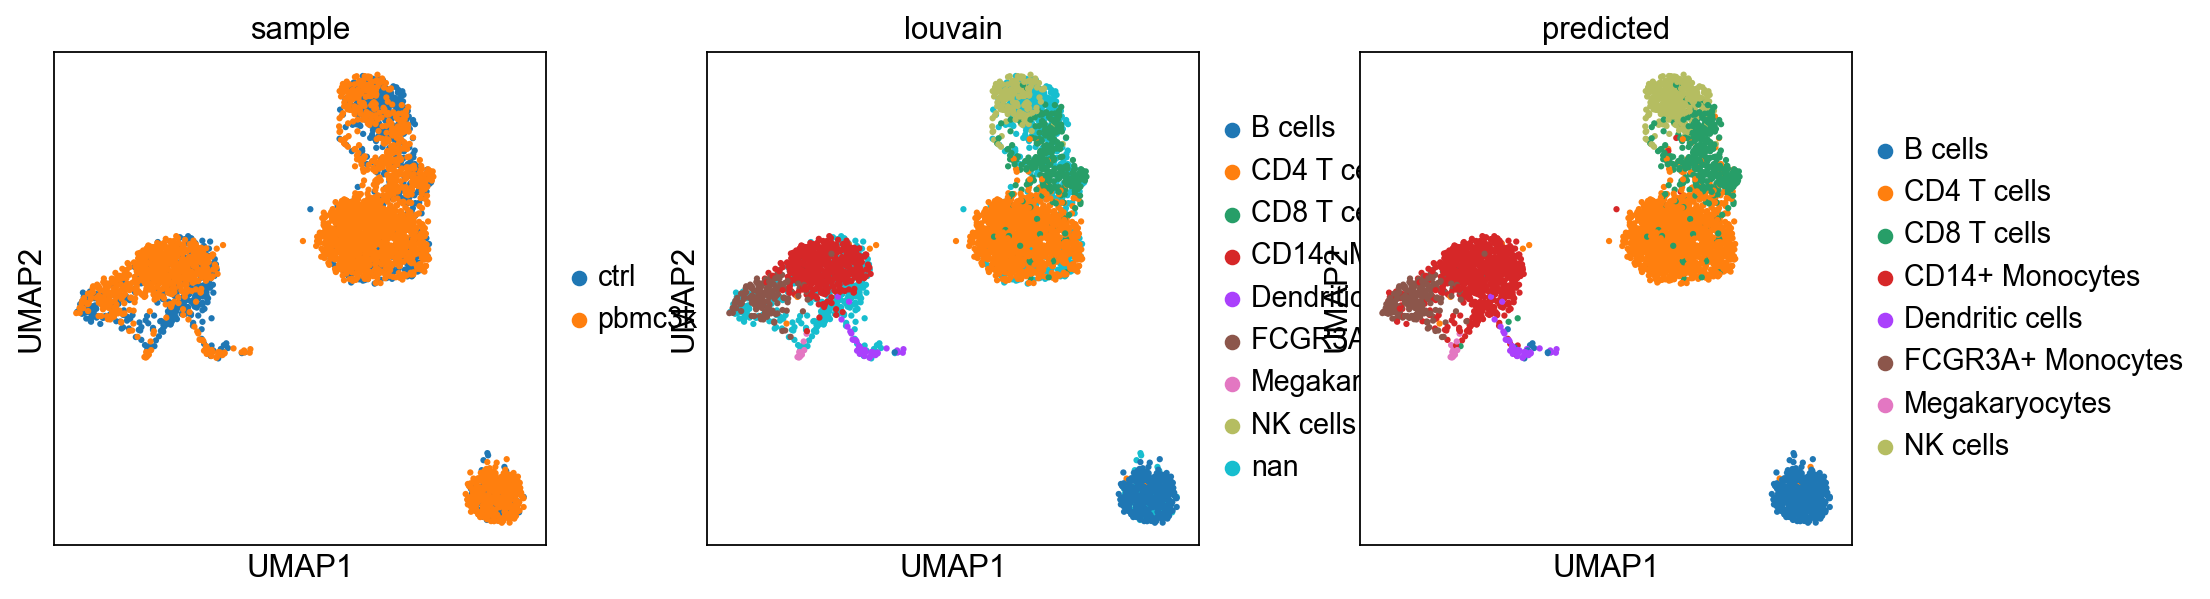

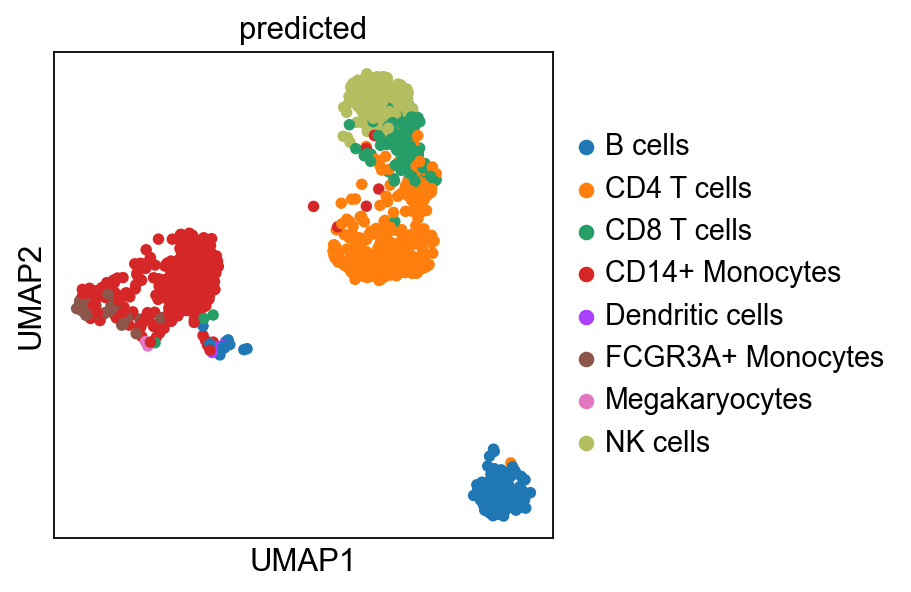

In [24]:
# add to merged object.
adata_merged.obs['predicted'] = class_def.append(adata_ref.obs['louvain']).tolist()

sc.pl.umap(adata_merged, color=["sample","louvain",'predicted'])
#plot only ctrl cells.
sc.pl.umap(adata_merged[adata_merged.obs['sample']=='ctrl'], color='predicted')

##Ingest

In [25]:
sc.tl.ingest(adata, adata_ref, obs='louvain')

running ingest
    finished (0:00:08)


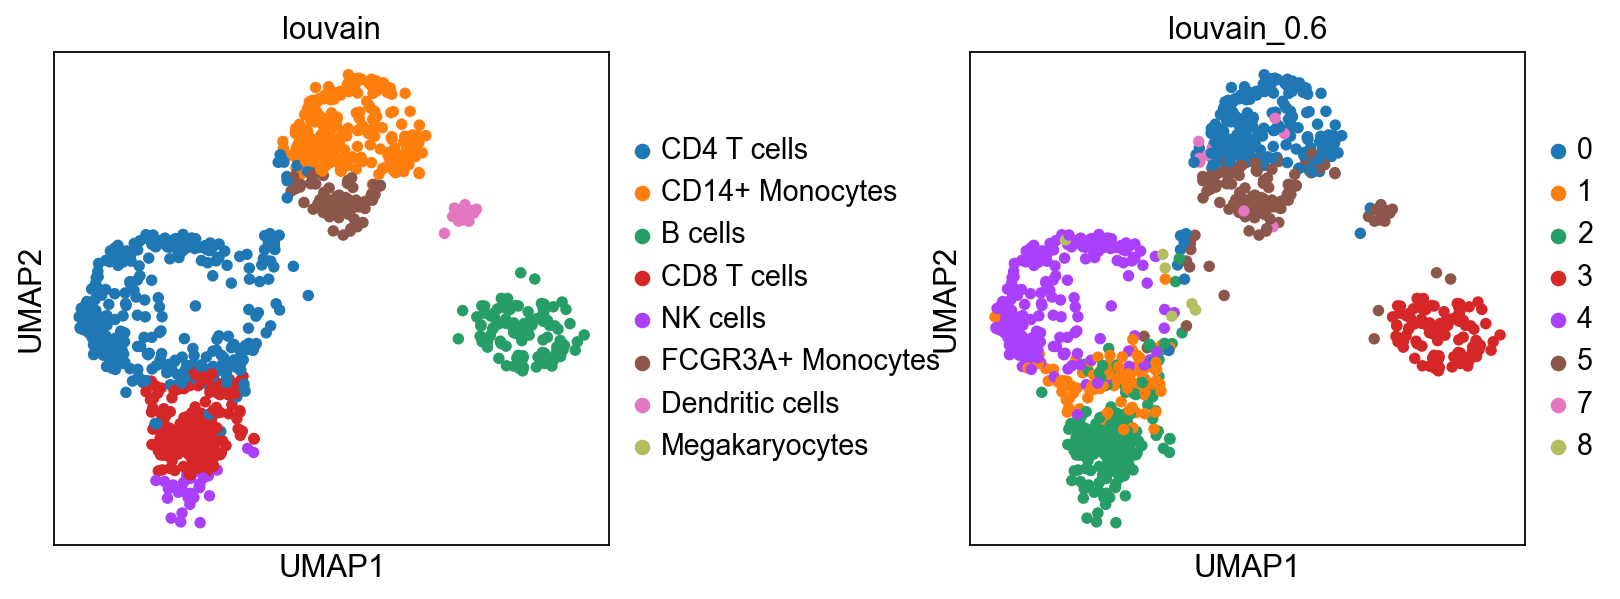

In [26]:
sc.pl.umap(adata, color=['louvain','louvain_0.6'], wspace=0.5)

## Compare results

The predictions from ingest is stored in the column 'louvain' while we named the label transfer with scanorama as 'predicted'

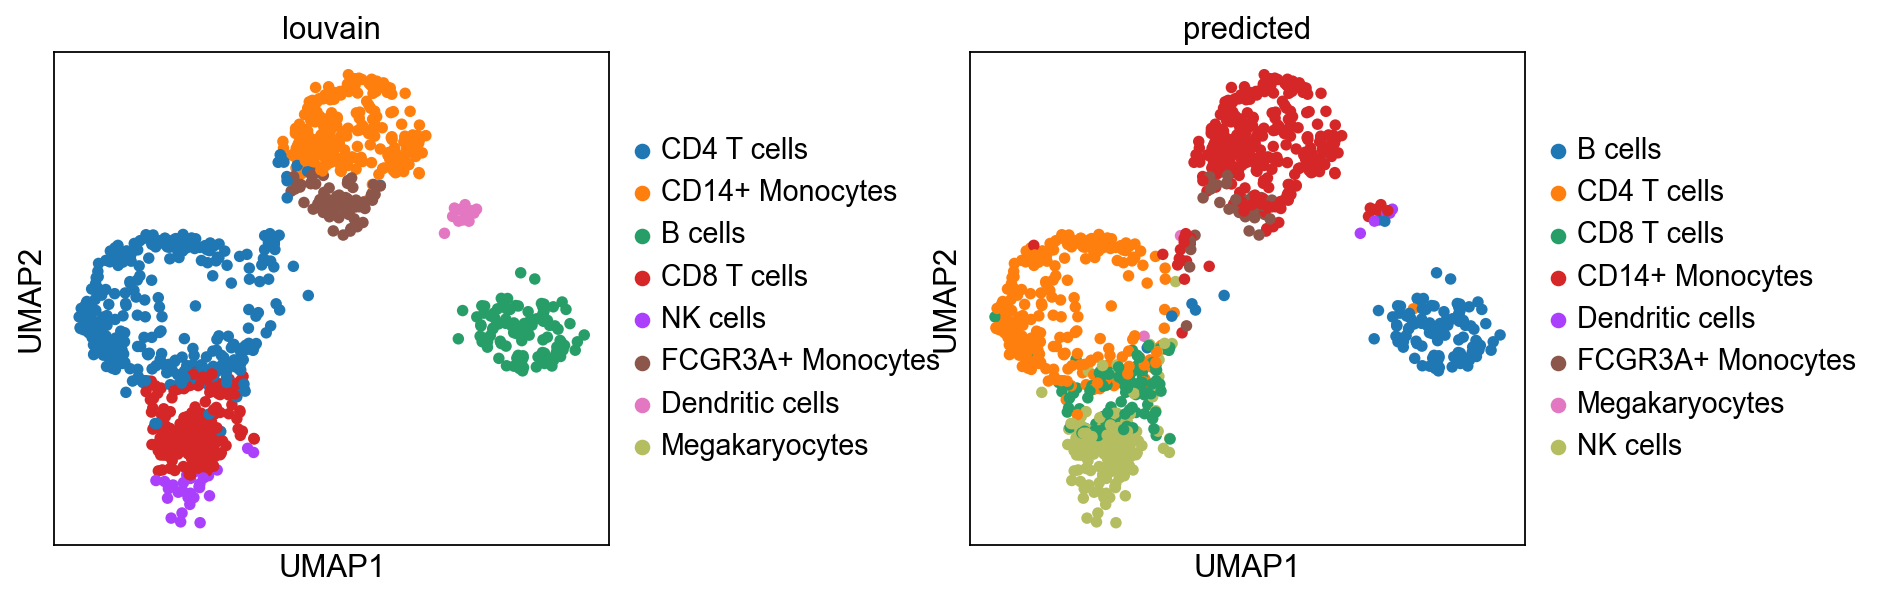

In [27]:
sc.pl.umap(adata, color=['louvain','predicted'], wspace=0.5)

As you can see, the main celltypes are the same, but dendritic cells are mainly predicted to cluster 8 by ingest and the proportions of the different celltypes are different. 

The only way to make sure which method you trust is to look at what genes the different celltypes express and use your biological knowledge to make decisions. 


There are many more methods for celltype predictions, both pretrained and based on a refernce dataset. Here was an example of two methods that can be used. Keep in mind that both what method you use, and what reference you chose will have an impact on the results.